In [1]:
import sys
sys.path.append("..")

from glob import glob
import matplotlib.pyplot as plt
from matplotlib import colormaps
import ipywidgets as ipw
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle

from quantizer import Quantizer
from lib.dataset_wrapper import Dataset
from lib import utils
from lib import abx_utils

In [2]:
ABX_NB_SAMPLES = 50
QUANTIZER_ABX_DISTANCE = {
    "quantized_latent": {
        "metric": "cosine",
        "weight": 1,
    }
}
NB_TRAINING = 5
REGULAR_MODALITIES = [["cepstrum"], ["art_params"], ["cepstrum", "art_params"]]
LATE_FUSION_DATASETS = ["pb2007"]
LATE_FUSION_MODALITIES = ["cepstrum", "art_params"]
LATE_FUSION_RANGE = [-1, 1]
LATE_FUSION_NB_STEPS = 10
LATE_FUSION_WEIGHTS = 10 ** np.linspace(*LATE_FUSION_RANGE, LATE_FUSION_NB_STEPS)

In [3]:
quantizers_path = glob("../out/quantizer/*/")
quantizers_path.sort()

In [4]:
quantizers_abx_matrices = utils.pickle_load("../out/quantizer/abx_cache.pickle", {})

In [5]:
for quantizer_path in tqdm(quantizers_path):    
    if quantizer_path not in quantizers_abx_matrices:
        quantizers_abx_matrices[quantizer_path] = {}
    quantizer_abx_matrices = quantizers_abx_matrices[quantizer_path]
    
    distance = QUANTIZER_ABX_DISTANCE
    distance_signature = abx_utils.get_distance_signature(distance)
    if distance_signature in quantizer_abx_matrices: continue
    
    quantizer = Quantizer.reload(quantizer_path)
    
    main_dataset = quantizer.main_dataset
    quantizer_lab = quantizer.get_datasplit_lab(2)
    quantizer_features = quantizer.autoencode_datasplit(2)

    consonants = main_dataset.phones_infos["consonants"]
    vowels = main_dataset.phones_infos["vowels"]
    consonants_indexes = abx_utils.get_datasets_phones_indexes(quantizer_lab, consonants, vowels)

    abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, quantizer_features, distance, ABX_NB_SAMPLES)
    quantizer_abx_matrices[distance_signature] = abx_matrix
    utils.pickle_dump("../out/quantizer/abx_cache.pickle", quantizers_abx_matrices)

  0%|          | 0/1214 [00:00<?, ?it/s]

In [6]:
final_quantizers_config = utils.read_yaml_file("quantizer_final_configs.yaml")
late_fusion_abx_matrices = utils.pickle_load("../out/quantizer/late_fusion_cache.pickle", {})

for late_fusion_dataset in LATE_FUSION_DATASETS:
    for i_training in tqdm(range(NB_TRAINING)):
        quantizers_features = {}
        quantizers_signature = []
        abx_distance = {}
        
        for late_fusion_modality in LATE_FUSION_MODALITIES:
            quantizer_config = final_quantizers_config["%s-%s" % (late_fusion_dataset, late_fusion_modality)]
            quantizer_config["dataset"]["datasplit_seed"] = i_training
            quantizer_signature = utils.get_variable_signature(quantizer_config)
            quantizer_path = "../out/quantizer/%s-%s/" % (quantizer_signature, i_training)
            quantizer = Quantizer.reload(quantizer_path)
            quantizer_features = quantizer.autoencode_datasplit(2)
            
            quantizers_signature.append(quantizer_signature)
            abx_distance[late_fusion_modality] = {
                "metric": "cosine",
                "weight": 1,
            }
            
            for dataset_name, dataset_features in quantizer_features.items():
                if dataset_name not in quantizers_features:
                    quantizers_features[dataset_name] = {}
                quantizers_features[dataset_name][late_fusion_modality] = {}
                
                for item_name, item_quantized_latent in dataset_features["quantized_latent"].items():
                    quantizers_features[dataset_name][late_fusion_modality][item_name] = item_quantized_latent
        
        main_dataset = quantizer.main_dataset
        quantizer_lab = quantizer.get_datasplit_lab(2)
        
        consonants = main_dataset.phones_infos["consonants"]
        vowels = main_dataset.phones_infos["vowels"]
        consonants_indexes = abx_utils.get_datasets_phones_indexes(quantizer_lab, consonants, vowels)

        for late_fusion_weight in tqdm(LATE_FUSION_WEIGHTS, leave=False):
            abx_distance[late_fusion_modality]["weight"] = late_fusion_weight
            distance_signature = abx_utils.get_distance_signature(abx_distance)
            cache_key = "%s-%s" % (abx_distance, i_training)
            if cache_key in late_fusion_abx_matrices: continue
            abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, quantizers_features, abx_distance, ABX_NB_SAMPLES)
            late_fusion_abx_matrices[cache_key] = abx_matrix
            utils.pickle_dump("../out/quantizer/late_fusion_cache.pickle", late_fusion_abx_matrices)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
distance_signature = abx_utils.get_distance_signature(QUANTIZER_ABX_DISTANCE)
final_quantizers_scores = {}

repeated_datasets = utils.read_yaml_file("repeated_datasets.yaml")

for config_name, config in final_quantizers_config.items():
    config_scores = {
        "global": [],
        "manner": [],
        "place": [],
    }
    dataset_name, modalities = config_name.split("-")
    
    if modalities.startswith("repeated"):
        repeated_type = "art"
        if modalities.endswith("cepstrum"):
            modalities = modalities[:-len("cepstrum")]
            repeated_type = "cepstrum"
    
    for i_training in range(NB_TRAINING):
        if modalities.startswith("repeated"):
            repeated_name = repeated_datasets[dataset_name][modalities][i_training]
            modality_name = "agent_%s_%s" % (repeated_type, repeated_name)
            config["dataset"]["data_types"] = [modality_name]
        
        config["dataset"]["datasplit_seed"] = i_training
        config_signature = utils.get_variable_signature(config)
        quantizer_path = "../out/quantizer/%s-%s/" % (config_signature, i_training)
        
        quantizer = Quantizer.reload(quantizer_path, load_nn=False)
        consonants = quantizer.main_dataset.phones_infos["consonants"]
        vowels = quantizer.main_dataset.phones_infos["vowels"]
        quantizer_abx_matrix = quantizers_abx_matrices[quantizer_path][distance_signature]
        quantizer_groups_score = abx_utils.get_groups_score(consonants, quantizer_abx_matrix, quantizer.main_dataset.phones_infos["consonant_groups"])
        quantizer_global_score = abx_utils.get_global_score(quantizer_abx_matrix)

        config_scores["global"].append(quantizer_global_score)
        config_scores["manner"].append(quantizer_groups_score["manner"])
        config_scores["place"].append(quantizer_groups_score["place"])

    config_datasets = ",".join(config["dataset"]["names"])
    if not modalities.startswith("repeated"):
        config_modalities = ",".join(config["dataset"]["data_types"])
    else:
        config_modalities = "%s %s" % (repeated_type, modalities)
    if config_datasets not in final_quantizers_scores:
        final_quantizers_scores[config_datasets] = {}
    final_quantizers_scores[config_datasets][config_modalities] = config_scores

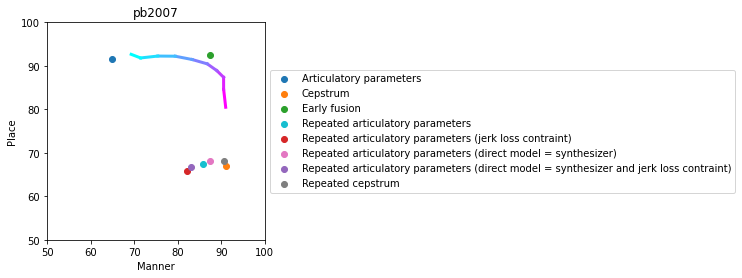

In [18]:
FUSION_COLORMAP = colormaps["cool"]
colors = {
    "cepstrum": "tab:orange",
    "art_params": "tab:blue",
    "cepstrum,art_params": "tab:green",
    "cepstrum repeated": "tab:grey",
    "art repeated": "tab:cyan",
    "art repeated_jerkloss": "tab:red",
    "art repeated_synthasdirect": "tab:pink",
    "art repeated_synthasdirect_jerkloss": "tab:purple",
}
labels = {
    "cepstrum": "Cepstrum",
    "art_params": "Articulatory parameters",
    "cepstrum,art_params": "Early fusion",
    "cepstrum repeated": "Repeated cepstrum",
    "art repeated": "Repeated articulatory parameters",
    "art repeated_jerkloss": "Repeated articulatory parameters (jerk loss contraint)",
    "art repeated_synthasdirect": "Repeated articulatory parameters (direct model = synthesizer)",
    "art repeated_synthasdirect_jerkloss": "Repeated articulatory parameters (direct model = synthesizer and jerk loss contraint)",
}

for late_fusion_dataset in LATE_FUSION_DATASETS:
    dataset = Dataset(late_fusion_dataset)
    consonants = dataset.phones_infos["consonants"]
    
    plt.figure()
    ax = plt.subplot(aspect="equal")
    ax.set_xlim(50, 100)
    ax.set_ylim(50, 100)
    ax.set_xlabel("Manner")
    ax.set_ylabel("Place")
    ax.set_title(late_fusion_dataset)
    
    
    for modality in final_quantizers_scores[late_fusion_dataset].keys():
        # modality = ",".join(modalities)
        modality_score = final_quantizers_scores[late_fusion_dataset][modality]
        color = colors[modality]
        
        # for i_training in range(NB_TRAINING):
        #     ax.scatter(modality_score["manner"][i_training], modality_score["place"][i_training], color=color, s=6)
            
        manner_mean = np.mean(modality_score["manner"])
        place_mean = np.mean(modality_score["place"])
        ax.scatter(manner_mean, place_mean, color=color, label=labels[modality])
    
    abx_distance = {}
    for late_fusion_modality in LATE_FUSION_MODALITIES:
        abx_distance[late_fusion_modality] = {
            "metric": "cosine",
            "weight": 1,
        }
    
    weights_score = []
    for i_weight, late_fusion_weight in enumerate(LATE_FUSION_WEIGHTS):
        weight_scores = {
            "manner": [],
            "place": [],
        }
        cmap_index = 1 - i_weight / (LATE_FUSION_NB_STEPS-1)
        weight_color = FUSION_COLORMAP(cmap_index)
        
        for i_training in range(NB_TRAINING):
            abx_distance[late_fusion_modality]["weight"] = late_fusion_weight
            
            distance_signature = abx_utils.get_distance_signature(abx_distance)
            cache_key = "%s-%s" % (abx_distance, i_training)
            abx_matrix = late_fusion_abx_matrices[cache_key]
            quantizer_groups_score = abx_utils.get_groups_score(consonants, abx_matrix, dataset.phones_infos["consonant_groups"])
            weight_scores["manner"].append(quantizer_groups_score["manner"])
            weight_scores["place"].append(quantizer_groups_score["place"])
            # ax.scatter(quantizer_groups_score["manner"], quantizer_groups_score["place"], color=weight_color, s=4)
        
        weight_score = {
            "manner": np.mean(weight_scores["manner"]),
            "place": np.mean(weight_scores["place"]),
        }
        weights_score.append(weight_score)
    
    for i_segment in range(LATE_FUSION_NB_STEPS-1):
        cmap_index = 1 - i_segment / (LATE_FUSION_NB_STEPS-2)
        segment_color = FUSION_COLORMAP(cmap_index)
        
        segment_start = weights_score[i_segment]
        segment_end = weights_score[i_segment+1]
        ax.plot((segment_start["manner"], segment_end["manner"]), (segment_start["place"], segment_end["place"]), color=segment_color, linewidth=3)
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [ ]:
FUSION_COLORMAP = colormaps["cool"]
colors = {
    "cepstrum": "tab:orange",
    "art_params": "tab:blue",
    "cepstrum,art_params": "tab:green",
}

for late_fusion_dataset in LATE_FUSION_DATASETS:
    dataset = Dataset(late_fusion_dataset)
    consonants = dataset.phones_infos["consonants"]
    nb_modalities = len(REGULAR_MODALITIES)
    
    plt.figure()
    ax = plt.subplot()
    # ax.set_xlim(50, 100)
    ax.set_ylim(50, 100)
    ax.set_title("Global ABX score (%s)" % late_fusion_dataset)
    
    for i_modality, modalities in enumerate(REGULAR_MODALITIES):
        modality = ",".join(modalities)
        modality_score = final_quantizers_scores[late_fusion_dataset][modality]
        color = colors[modality]
        
        # for i_training in range(NB_TRAINING):
        #     ax.scatter(modality_score["manner"][i_training], modality_score["place"][i_training], color=color, s=6)
        
        global_mean = np.mean(modality_score["global"])
        ax.bar(i_modality, global_mean, color=color)
    
    abx_distance = {}
    for late_fusion_modality in LATE_FUSION_MODALITIES:
        abx_distance[late_fusion_modality] = {
            "metric": "cosine",
            "weight": 1,
        }
    
    weights_score = []
    for i_weight, late_fusion_weight in enumerate(LATE_FUSION_WEIGHTS):
        weight_scores = []
        cmap_index = 1 - i_weight / (LATE_FUSION_NB_STEPS-1)
        weight_color = FUSION_COLORMAP(cmap_index)
        
        for i_training in range(NB_TRAINING):
            abx_distance[late_fusion_modality]["weight"] = late_fusion_weight
            
            distance_signature = abx_utils.get_distance_signature(abx_distance)
            cache_key = "%s-%s" % (abx_distance, i_training)
            abx_matrix = late_fusion_abx_matrices[cache_key]
            quantizer_global_score = abx_utils.get_global_score(abx_matrix)
            weight_scores.append(quantizer_global_score)
        
        weight_score = np.mean(weight_scores)
        ax.bar(nb_modalities + i_weight, weight_score, color=weight_color)
    
    plt.show()

In [ ]:
final_quantizers_variations = {}

for config_name, config in final_quantizers_config.items():
    consonants_units_change = 0
    consonants_len = 0
    
    _, modalities = config_name.split("-")
    if modalities.startswith("repeated"):
        continue
    
    for i_training in range(NB_TRAINING):
        config["dataset"]["datasplit_seed"] = i_training
        config_signature = utils.get_variable_signature(config)
        quantizer_path = "../out/quantizer/%s-%s/" % (config_signature, i_training)
        
        quantizer = Quantizer.reload(quantizer_path)
        main_dataset = quantizer.main_dataset
        consonants = main_dataset.phones_infos["consonants"]
        quantizer_lab = quantizer.get_datasplit_lab(2)
        quantizer_features = quantizer.autoencode_datasplit(2)
        consonants_indexes = abx_utils.get_datasets_phones_indexes(quantizer_lab, consonants, vowels)
        
        for consonant_name, consonant_indexes in consonants_indexes.items():
            for consonant_index in consonant_indexes:
                consonant_units = np.argmax(abx_utils.get_phone_features(quantizer_features, "quantized_index", consonant_index), axis=1)
                nb_change = np.abs(np.diff(consonant_units)).clip(0, 1).sum()
                nb_frames = len(consonant_units)
                consonants_units_change += nb_change
                consonants_len += nb_frames

    config_datasets = ",".join(config["dataset"]["names"])
    config_modalities = ",".join(config["dataset"]["data_types"])
    if config_datasets not in final_quantizers_variations:
        final_quantizers_variations[config_datasets] = {}
    final_quantizers_variations[config_datasets][config_modalities] = consonants_units_change / consonants_len * 100

In [ ]:
FUSION_COLORMAP = colormaps["cool"]
colors = {
    "cepstrum": "tab:orange",
    "art_params": "tab:blue",
    "cepstrum,art_params": "tab:green",
}

for late_fusion_dataset in LATE_FUSION_DATASETS:
    dataset = Dataset(late_fusion_dataset)
    consonants = dataset.phones_infos["consonants"]
    nb_modalities = len(REGULAR_MODALITIES)
    
    plt.figure()
    ax = plt.subplot()
    ax.set_title("Units variation %% during consonants (%s)" % late_fusion_dataset)
    xticks = []
    
    for i_modality, modalities in enumerate(REGULAR_MODALITIES):
        modality = ",".join(modalities)
        xticks.append(modality)
        
        modality_score = final_quantizers_variations[late_fusion_dataset][modality]
        color = colors[modality]
        
        # for i_training in range(NB_TRAINING):
        #     ax.scatter(modality_score["manner"][i_training], modality_score["place"][i_training], color=color, s=6)
        
        ax.bar(i_modality, modality_score, color=color)
    ax.set_xticks(range(len(xticks)), xticks)
    
    plt.show()